<a href="https://colab.research.google.com/github/TobyOmondi/Driver-Drowsiness-Detection-System/blob/main/Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required libraries and modules

In [2]:
#import python libraries and modules
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model
import cv2

# Listing the labels (subdirectories) in the train Dataset directory.

In [3]:
#Dataset Labels
labels = os.listdir("/content/drive/MyDrive/dataset/train")
print(labels)

['Closed', 'Open', 'yawn', 'no_yawn']


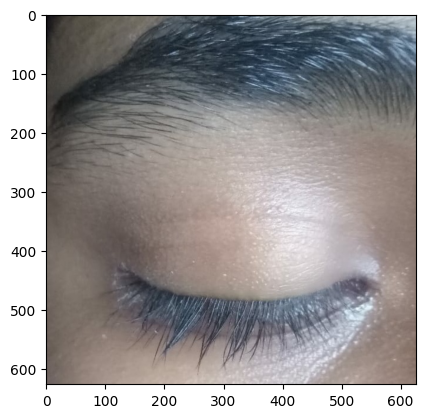

In [4]:
#Visualize a Random Image
plt.imshow(plt.imread("/content/drive/MyDrive/dataset/train/Closed/_600.jpg"))

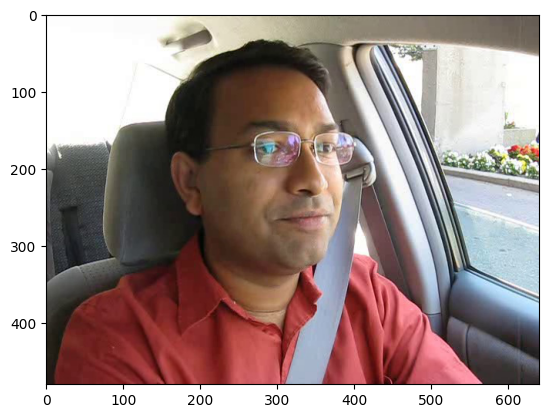

In [5]:
#VISUALIZE YAWN IMAGE
plt.imshow(plt.imread("/content/drive/MyDrive/dataset/train/no_yawn/112.jpg"))

In [6]:
a = plt.imread("/content/drive/MyDrive/dataset/train/yawn/243.jpg") #Image Array
a.shape #Image Shape

(480, 640, 3)

# Obtain face images for yawn and no_yawn categories

In [7]:
def face_for_yawn(direc="/content/drive/MyDrive/dataset/train", face_cas_path="/content/haarcascade_frontalface_alt.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# Obtain face images for "Closed" and "Open" eye categories

In [8]:
def get_data(dir_path="/content/drive/MyDrive/dataset/train", face_cas_path="/content/haarcascade_lefteye_2splits.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

# New variable to store

In [9]:
new_data = face_for_yawn() + get_data()
# Shuffle the new_data
np.random.shuffle(new_data)

0
1
2
3


# Separate label and features

In [10]:
# Create the feature (X) and label (y) arrays
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)
X_train = np.array(X)
y_train = np.array(y)

In [11]:
#Reshape X to match the input shape of the model
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# Use the LabelBinarizer class to convert the labels to one-hot encoded vectors

In [12]:
# Use the LabelBinarizer class to convert the labels to one-hot encoded vectors
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [13]:
y = np.array(y)

# Split the data into training and test sets

In [14]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [15]:
len(X_test)

456

# import some dependancies

In [16]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmetation for training set

In [17]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

# Rescale the test set
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

#  Create a sequential model

In [18]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

# Train the Model

In [19]:
history = model.fit(train_generator, epochs=65, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/65
34/34 [==============================] - 239s 7s/step - loss: 1.2016 - accuracy: 0.4483 - val_loss: 1.0286 - val_accuracy: 0.6711
Epoch 2/65
34/34 [==============================] - 232s 7s/step - loss: 0.5352 - accuracy: 0.7904 - val_loss: 0.4274 - val_accuracy: 0.8158
Epoch 3/65
34/34 [==============================] - 229s 7s/step - loss: 0.4053 - accuracy: 0.8477 - val_loss: 0.2865 - val_accuracy: 0.8947
Epoch 4/65
34/34 [==============================] - 226s 7s/step - loss: 0.3294 - accuracy: 0.8675 - val_loss: 0.2120 - val_accuracy: 0.9189
Epoch 5/65
34/34 [==============================] - 227s 7s/step - loss: 0.2794 - accuracy: 0.8919 - val_loss: 0.1935 - val_accuracy: 0.9320
Epoch 6/65
34/34 [==============================] - 227s 7s/step - loss: 0.2310 - accuracy: 0.9098 - val_loss: 0.2130 - val_accuracy: 0.9167
Epoch 7/65
34/34 [==============================] - 228s 7s/step - loss: 0.2238 - accuracy: 0.9164 - val_loss: 0.1873 - val_accuracy: 0.9254
Epoch 8/65
34

# Model Evaluation.

In [20]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(test_generator)
y_true = label_bin.inverse_transform(y_test)
y_pred = label_bin.inverse_transform(y_pred)

# Calculate metrics
report = classification_report(y_true, y_pred)
print(report)

15/15 [==============================] - 25s 2s/step
              precision    recall  f1-score   support

           0       0.97      0.82      0.89        45
           1       0.88      0.98      0.93        51
           2       0.97      1.00      0.99       181
           3       1.00      0.98      0.99       179

    accuracy                           0.97       456
   macro avg       0.96      0.95      0.95       456
weighted avg       0.97      0.97      0.97       456



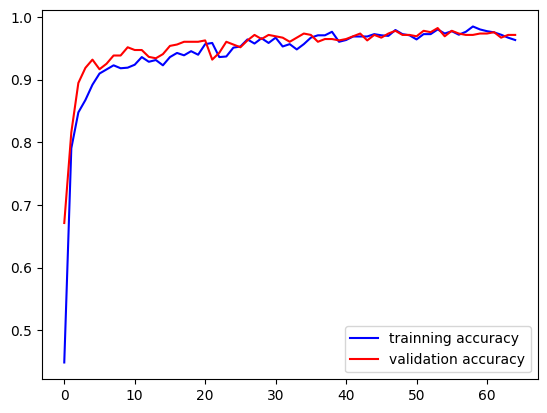

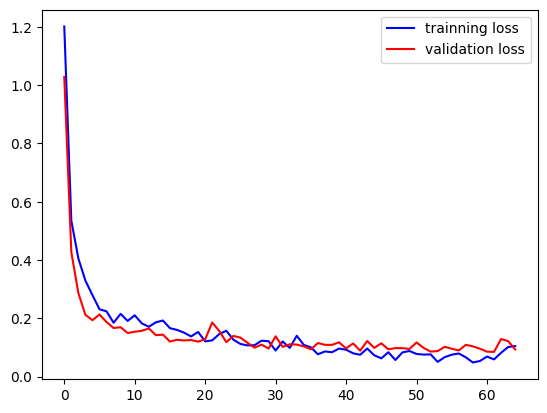

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [22]:
model.save("Model.h5")